In [126]:
%pylab inline

from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

from soln.dataset import get_augmented_train_and_test_set
from soln.dataset import get_component_info_df
from soln.dataset import load_raw_components

pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [127]:
comp_types, group_dfs = load_raw_components()
straight = group_dfs['straight']
for feat in ('groove', 'unique_feature', 'orientation'):
    straight[feat] = (straight[feat] == 'Yes')
straight.info()

ValueError: too many values to unpack

In [62]:
# Convert mj_class_code to binary features.
straight.mj_class_code.fillna('MJ-other', inplace=True)
print straight.mj_class_code.value_counts()
lb = LabelBinarizer()
bin_feats = lb.fit_transform(straight.mj_class_code.values)
print lb.classes_
tmp_df = pd.DataFrame(bin_feats, columns=lb.classes_)
straight = straight.join(tmp_df)
straight.pop('mj_class_code')
straight.info()

MJ-other    241
MJ-003       71
MJ-001       46
MJ-002        2
MJ-007        1
dtype: int64
['MJ-001' 'MJ-002' 'MJ-003' 'MJ-007' 'MJ-other']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 16 columns):
component_id         361 non-null object
component_type_id    361 non-null object
bolt_pattern_long    291 non-null float64
bolt_pattern_wide    204 non-null float64
head_diameter        70 non-null float64
overall_length       41 non-null float64
thickness            361 non-null float64
groove               361 non-null bool
unique_feature       361 non-null bool
orientation          361 non-null bool
weight               354 non-null float64
MJ-001               361 non-null int64
MJ-002               361 non-null int64
MJ-003               361 non-null int64
MJ-007               361 non-null int64
MJ-other             361 non-null int64
dtypes: bool(3), float64(6), int64(5), object(2)
memory usage: 40.5+ KB


In [63]:
# Convert component_type_id to binary features.
print straight.component_type_id.value_counts()
lb = LabelBinarizer()
bin_feats = lb.fit_transform(straight.component_type_id.values)
print lb.classes_
tmp_df = pd.DataFrame(bin_feats, columns=lb.classes_)
straight = straight.join(tmp_df)
straight.pop('component_type_id')
straight.info()

CP-002    93
CP-004    85
CP-003    83
CP-006    45
CP-001    28
CP-007    25
CP-005     2
dtype: int64
['CP-001' 'CP-002' 'CP-003' 'CP-004' 'CP-005' 'CP-006' 'CP-007']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 22 columns):
component_id         361 non-null object
bolt_pattern_long    291 non-null float64
bolt_pattern_wide    204 non-null float64
head_diameter        70 non-null float64
overall_length       41 non-null float64
thickness            361 non-null float64
groove               361 non-null bool
unique_feature       361 non-null bool
orientation          361 non-null bool
weight               354 non-null float64
MJ-001               361 non-null int64
MJ-002               361 non-null int64
MJ-003               361 non-null int64
MJ-007               361 non-null int64
MJ-other             361 non-null int64
CP-001               361 non-null int64
CP-002               361 non-null int64
CP-003               361 non-null int6

In [64]:
# Add features to capture whether a value is missing, and fill missing values with average.
for feat in ('bolt_pattern_long', 'bolt_pattern_wide', 'head_diameter', 'overall_length', 'weight'):
    straight[feat + '_missing'] = straight[feat].isnull()
    straight[feat].fillna(straight[feat].mean(), inplace=True)
straight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 27 columns):
component_id                 361 non-null object
bolt_pattern_long            361 non-null float64
bolt_pattern_wide            361 non-null float64
head_diameter                361 non-null float64
overall_length               361 non-null float64
thickness                    361 non-null float64
groove                       361 non-null bool
unique_feature               361 non-null bool
orientation                  361 non-null bool
weight                       361 non-null float64
MJ-001                       361 non-null int64
MJ-002                       361 non-null int64
MJ-003                       361 non-null int64
MJ-007                       361 non-null int64
MJ-other                     361 non-null int64
CP-001                       361 non-null int64
CP-002                       361 non-null int64
CP-003                       361 non-null int64
CP-004               

In [65]:
# Get list of vectors to work with.
straight.set_index('component_id', drop=True, inplace=True)
straight_np = straight.astype(np.float).values
straight_np.shape

(361, 26)

In [68]:
# Approach 1: Cluster agglomeratively, then extract flat clusters.

from scipy.cluster.hierarchy import linkage
from scipy.cluster.vq import whiten
y = whiten(straight_np)
%time Z = linkage(y, method='ward')

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 41.3 ms


CPU times: user 1.28 s, sys: 24 ms, total: 1.3 s
Wall time: 1.32 s


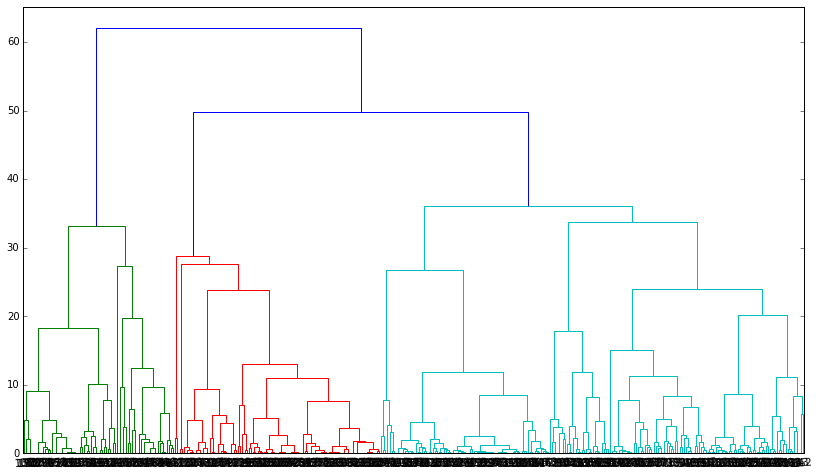

In [79]:
from scipy.cluster.hierarchy import dendrogram
figsize(14, 8)
%time out = dendrogram(Z)

In [128]:
from scipy.cluster import hierarchy
fcluster = hierarchy.fcluster(Z, 20.0, criterion='distance')
print fcluster.shape, np.min(fcluster), np.max(fcluster)

(361,) 1 13


In [143]:
# Approach 2: Use K-means

from scipy.cluster import vq

y = vq.whiten(straight_np)
codebook, distortion = vq.kmeans(y, 20)
print len(codebook), distortion
fcluster, _ = vq.vq(y, codebook)

20 1.69455514026


In [144]:
cid_to_clu = pd.Series(fcluster, index=straight.index, name='cluster')
cid_to_clu.sort()
cid_to_clu = cid_to_clu.reset_index()
cid_to_clu.cluster.value_counts()

0     42
18    39
19    30
12    29
14    27
15    27
10    25
9     21
4     15
16    15
8     15
1     13
13    12
17    10
6      9
3      9
11     7
7      7
5      7
2      2
dtype: int64

In [145]:
fcluster_str = ["straight_clu_{}".format(clu) for clu in fcluster]
cid_to_clu_str = pd.Series(fcluster_str, index=straight.index, name='cluster')
cid_to_clu_str = cid_to_clu_str.reset_index()
cid_to_clu_str.to_csv("clu_straight.csv", index=False)

In [112]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
%time pca.fit(straight_np)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.1 ms


PCA(copy=True, n_components=2, whiten=True)

In [113]:
pca.explained_variance_ratio_

array([ 0.67927172,  0.17201545])

(361, 2)


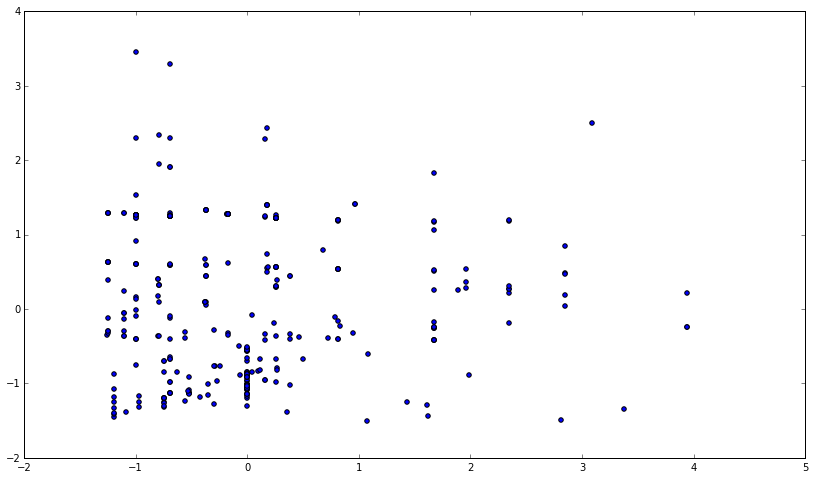

In [116]:
pts = pca.transform(straight_np)
print pts.shape
scatter(pts[:, 0], pts[:, 1])